## Vector Autoregression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.graphics.tsaplots import plot_acf

np.random.seed(3)

In [2]:
with open("./data/heat_data.pkl", "rb") as f:
    loaded_heat_data = pickle.load(f)
    
with open("./data/elec_data.pkl", "rb") as f:
    loaded_elec_data = pickle.load(f)

In [3]:
import math

def test_train_validate_split(df: pd.DataFrame, percentages=(0.70,0.10,0.20)):
    return np.split(df, [int(percentages[0] * len(df)), int((percentages[0] + percentages[1]) * len(df))])

In [53]:
df_elec_data = pd.concat([loaded_elec_data["df_elec_train"], loaded_elec_data["df_elec_validate"], loaded_elec_data["df_elec_test"]])
df_elec_data = df_elec_data.resample("W").mean()

df_elec_train, df_elec_validate, df_elec_test = test_train_validate_split(df_elec_data)
df_elec_test.shape

/home/ivan/anaconda3/envs/weather-prediction/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


(84, 4)

### Sanity Check

In [54]:
assert loaded_heat_data["df_heat_train"].shape == (49056, 6)
assert loaded_heat_data["df_heat_test"].shape == (14017, 6)
assert loaded_heat_data["df_heat_validate"].shape == (7007, 6)

assert loaded_elec_data["df_elec_train"].shape == (49056, 4)
assert loaded_elec_data["df_elec_test"].shape == (14017, 4)
assert loaded_elec_data["df_elec_validate"].shape == (7007, 4)

In [55]:
def display_time_series(df_train, df_validate, df_test, col="", figsize=(15,5), title="", ):
    ax = df_train[col].plot(figsize=figsize, color="tab:blue", label="Train")
    _ = df_test[col].plot(ax=ax, color="tab:red", label="Test")
    _ = df_validate[col].plot(ax=ax, color="tab:orange", label="Validate")
    
    ax.legend()
    ax.axvline(df_validate.index[0], linestyle=":")
    ax.axvline(df_test.index[0], linestyle=":")
    
    plt.title(title)
    plt.show()

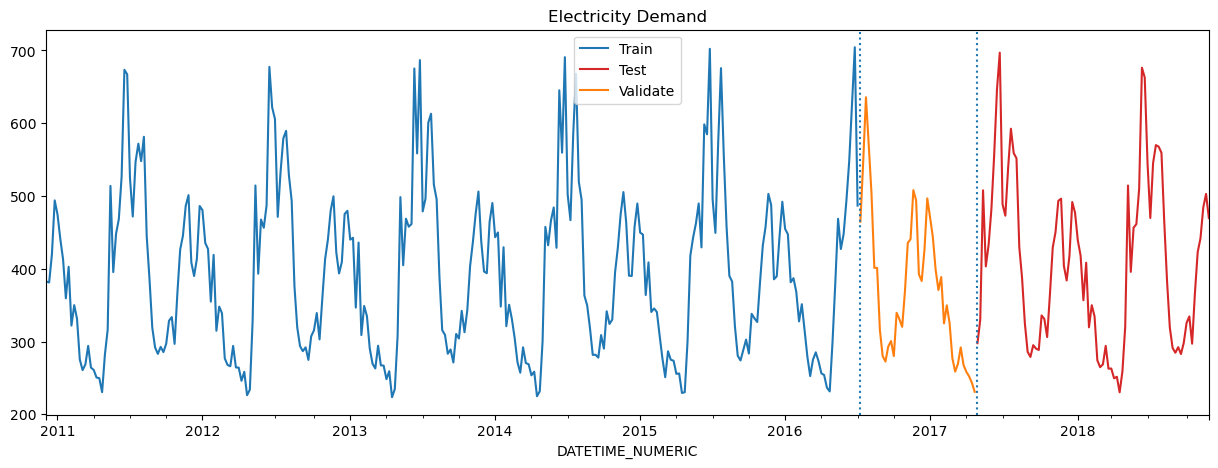

In [56]:
# display_time_series(df_heat_train, df_heat_validate, df_heat_test, col="heat_demand_values[kw]", title="Heat Demand")
display_time_series(df_elec_train, df_elec_validate, df_elec_test, col="electricity_demand_values[kw]", title="Electricity Demand")

## Predicting Electricity Demand

In [57]:
print(f"Train Period: {df_elec_train.index.min()}      ===> {df_elec_train.index.max()} shape: {df_elec_train.shape}")
print(f"Validation Period: {df_elec_validate.index.min()} ===> {df_elec_validate.index.max()} shape: {df_elec_validate.shape}")
print(f"Test Period: {df_elec_test.index.min()}       ===> {df_elec_test.index.max()} shape: {df_elec_test.shape}")


Train Period: 2010-12-05 00:00:00      ===> 2016-07-03 00:00:00 shape: (292, 4)
Validation Period: 2016-07-10 00:00:00 ===> 2017-04-23 00:00:00 shape: (42, 4)
Test Period: 2017-04-30 00:00:00       ===> 2018-12-02 00:00:00 shape: (84, 4)


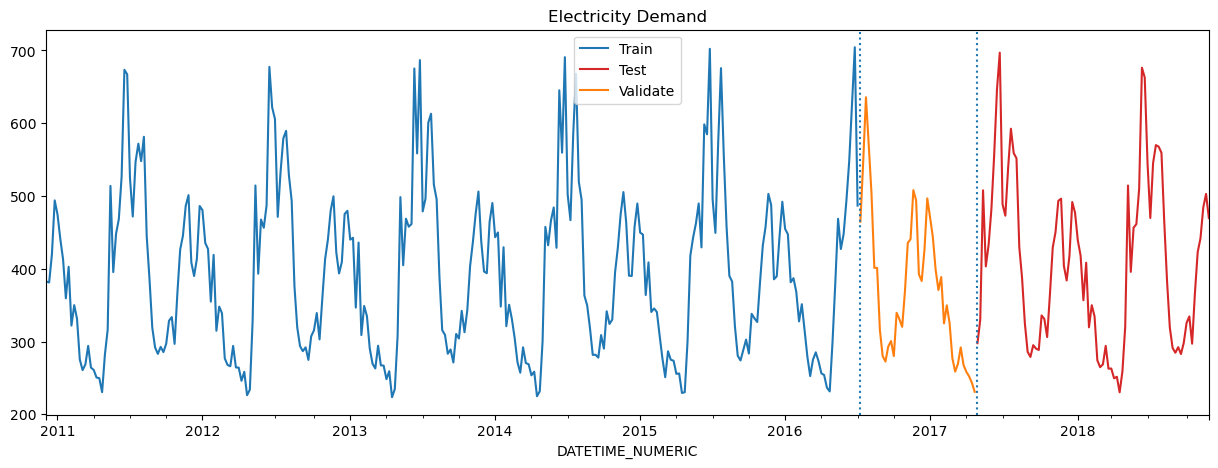

In [58]:
display_time_series(df_elec_train, df_elec_validate, df_elec_test, col="electricity_demand_values[kw]", title="Electricity Demand")


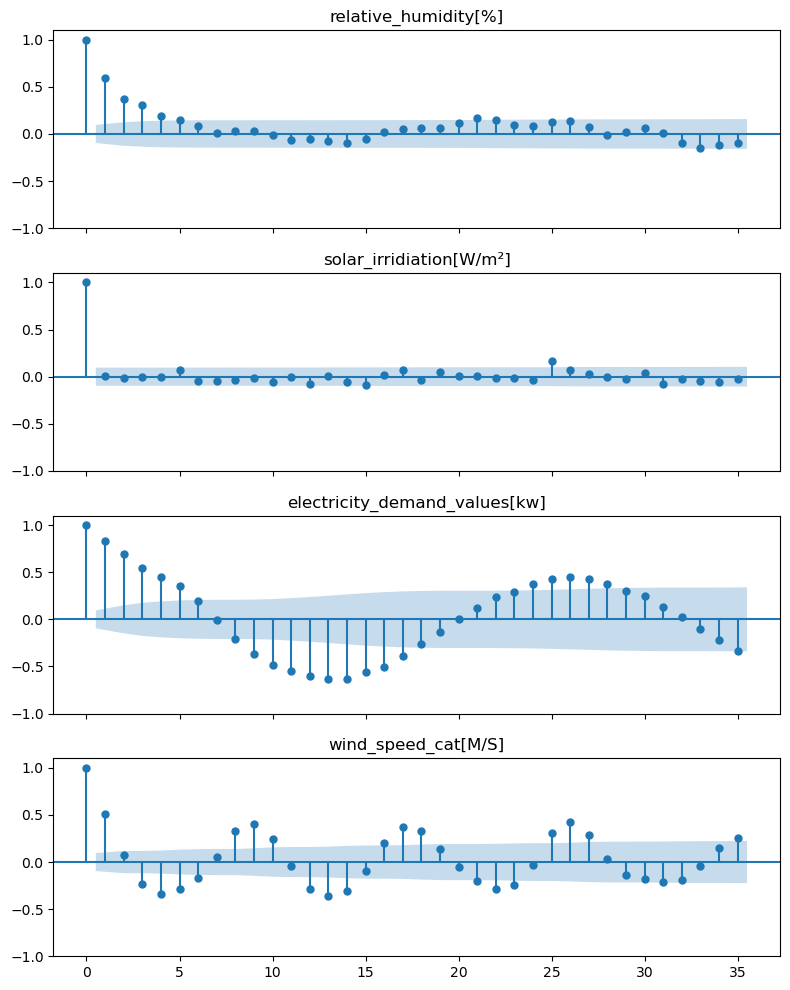

In [59]:
# Autocorrelation plot
# ======================================================================================
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 10), sharex=True)
axes = axes.flat
for i, col in enumerate(df_elec_data.columns):
    plot_acf(df_elec_data[col], ax=axes[i], lags=7*5)
    axes[i].set_ylim(-1, 1.1)
    axes[i].set_title(f'{col}')
fig.tight_layout()
plt.show()

In [124]:
from sklearn.ensemble import  HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries

In [125]:
df_elec_data.head()

,relative_humidity[%],solar_irridiation[W/m²],electricity_demand_values[kw],wind_speed_cat[M/S]
DATETIME_NUMERIC,,,,
2010-12-05,64.516667,262.116667,382.724679,5.391667
2010-12-12,63.988095,276.958333,381.154926,5.273810
2010-12-19,73.166667,267.613095,419.930448,5.119048
2010-12-26,68.779762,258.523810,493.969037,5.279762
2011-01-02,69.196429,245.309524,474.827742,4.702381


In [160]:
items = list(df_elec_data.columns)


forecaster_ms = ForecasterAutoregMultiSeries(
    regressor         = HistGradientBoostingRegressor(random_state=42, learning_rate=0.2),
    lags              = 112,
    transformer_series= StandardScaler()
)

multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster         = forecaster_ms,
                                       series             = df_elec_data,
                                       levels             = items,
                                       steps              = 7,
                                       metric             = 'mean_absolute_error',
                                       initial_train_size = len(df_elec_train) + len(df_elec_validate),
                                       refit              = False,
                                       fixed_train_size   = False,
                                       verbose            = False,
                                       show_progress      = True                                   )

  0%|          | 0/12 [00:00<?, ?it/s]

In [161]:
print("Backtest metrics")
display(multi_series_mae)
print("")
print("Backtest predictions")
predictions_ms.head(4)

Backtest metrics


,levels,mean_absolute_error
0,relative_humidity[%],4.153662
1,solar_irridiation[W/m²],5.898776
2,electricity_demand_values[kw],25.474760
3,wind_speed_cat[M/S],0.321411



Backtest predictions


,relative_humidity[%],solar_irridiation[W/m²],electricity_demand_values[kw],wind_speed_cat[M/S]
2017-04-30,58.713257,252.641225,318.181296,4.746723
2017-05-07,53.822211,257.920835,412.807795,4.438968
2017-05-14,55.016458,260.773645,435.774821,4.565632
2017-05-21,59.085756,259.862982,444.247953,4.587886


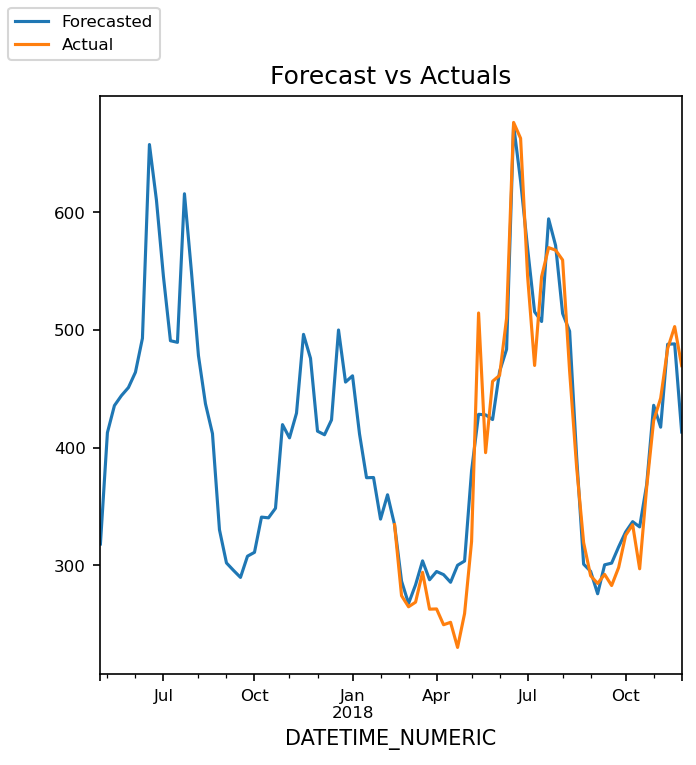

In [162]:
# plotting forecast vs actuals
fig = plt.figure(dpi=150, figsize=(5,5))
predictions_ms["electricity_demand_values[kw]"].plot(label="Forecasted")
df_elec_test["electricity_demand_values[kw]"][-len(df_elec_validate):].plot(label="Actual", fontsize=8)
plt.title("Forecast vs Actuals", fontsize=12)
fig.legend(loc='upper left', fontsize=8)

## Hyper Parameter Optimization

In [163]:
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

In [164]:
lags_grid = [24,48,72,96,120]
param_grid = {'learning_rate': [0.01,0.05, 0.1,0.15,0.2,0.25,0.30, 1]}

levels = ['electricity_demand_values[kw]'] # optimize for electricity_demand_values

results = grid_search_forecaster_multiseries(
              forecaster          = forecaster_ms,
              series              = df_elec_data,
              exog                = None,
              levels              = levels,
              lags_grid           = lags_grid,
              param_grid          = param_grid,
              steps               = 24,
              metric              = ['mean_absolute_error', "mean_absolute_percentage_error", "mean_squared_log_error"],
              initial_train_size  = len(df_elec_train),
              refit               = True,
              fixed_train_size    = True,
              return_best         = False,
              verbose             = False
          )
results

40 models compared for 1 level(s). Number of iterations: 40.


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/8 [00:00<?, ?it/s]

,levels,lags,params,mean_absolute_error,mean_absolute_percentage_error,mean_squared_log_error,learning_rate
34,[electricity_demand_values[kw]],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'learning_rate': 0.1},19.569441,0.050181,0.004089,0.10
33,[electricity_demand_values[kw]],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'learning_rate': 0.05},19.898812,0.051009,0.004019,0.05
36,[electricity_demand_values[kw]],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'learning_rate': 0.2},21.761965,0.056332,0.004768,0.20
37,[electricity_demand_values[kw]],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'learning_rate': 0.25},22.245219,0.057466,0.005275,0.25
25,[electricity_demand_values[kw]],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'learning_rate': 0.05},23.594420,0.060426,0.005663,0.05
38,[electricity_demand_values[kw]],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'learning_rate': 0.3},24.009152,0.061134,0.005876,0.30
28,[electricity_demand_values[kw]],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'learning_rate': 0.2},24.413761,0.067291,0.007240,0.20
26,[electricity_demand_values[kw]],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'learning_rate': 0.1},24.871701,0.066245,0.006708,0.10
35,[electricity_demand_values[kw]],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'learning_rate': 0.15},25.010431,0.069871,0.010261,0.15
27,[electricity_demand_values[kw]],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'learning_rate': 0.15},25.050421,0.066974,0.007391,0.15
